# AI-Powered Predictive Analytics for Early Detection of Mental Health Risks

**GOAL**: Build an AI system that takes students’ behavioural, academic, and survey data and predicts their risk level for mental health challenges (e.g., stress, anxiety, depression) before symptoms become severe. This enables early intervention by university counsellors or support systems.

## 1. Imports and environment setup

In [1]:
# Standard data libraries
import pandas as pd
import numpy as np

# Visualization (for analysis & explainability)
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load dataset

Load the CSV file you uploaded. Update the path if your file is elsewhere.

In [2]:
# Read into a pandas DataFrame
df = pd.read_csv("/content/students_mental_health_survey.csv")
print("Initial Shape:", df.shape)
df.head()

Initial Shape: (7022, 20)


,Age,Course,Gender,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type
0,25,Others,Male,3.56,3,3,2,Good,Moderate,Good,Moderate,Married,Never,Never,No,No,2,Moderate,17,On-Campus
1,24,Engineering,Female,2.44,0,3,0,Average,Low,Average,Low,Single,Occasionally,Occasionally,No,No,3,Low,27,On-Campus
2,19,Business,Female,3.74,4,0,3,Good,Low,Average,Moderate,In a Relationship,Never,Occasionally,No,No,4,High,15,On-Campus
3,19,Computer Science,Male,3.65,2,1,0,Average,Low,Average,Moderate,Single,NaN,Never,No,No,4,Moderate,20,Off-Campus
4,18,Business,Male,3.40,3,3,4,Good,Low,Average,High,Married,Never,Never,No,Yes,0,High,23,On-Campus


## 3: Normalize Strings & Replace Placeholders

In [3]:
str_cols = df.select_dtypes(include=["object"]).columns.tolist()

if str_cols:
    df[str_cols] = df[str_cols].apply(lambda s: s.astype(str).str.strip().str.lower())

# Replace placeholders with NaN
df.replace(
    {"n/a": np.nan, "na": np.nan, "none": np.nan, "null": np.nan, "": np.nan, "-": np.nan, "?": np.nan},
    inplace=True
)

In [4]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)
print("Shape after removing duplicates:", df.shape)

Shape after removing duplicates: (7022, 20)


## 4. Create target variable `Risk_Level`

We convert Stress, Depression, and Anxiety scores into a single risk label. Adjust bin edges if needed.

In [5]:
score_cols = ["Stress_Level", "Depression_Score", "Anxiety_Score"]
missing = [c for c in score_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns for target creation: {missing}")

# Convert to numeric (invalid → NaN)
for c in score_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Combined score
df["combined_score"] = df[score_cols].sum(axis=1, min_count=1)

# Option A: Fixed bins (adjust if needed)
# bins = [-1, 4, 8, np.inf]
# labels = ["Low", "Medium", "High"]

# Option B: Balanced bins (quantile-based)
labels = ["Low", "Medium", "High"]
df["Risk_Level"] = pd.qcut(df["combined_score"], q=[0, 1/3, 2/3, 1.0],
                           labels=labels, duplicates="drop")

df["Risk_Level"] = df["Risk_Level"].astype("category").cat.set_categories(labels, ordered=True)

print("\nTarget distribution:\n", df["Risk_Level"].value_counts(dropna=False))


Target distribution:
 Risk_Level
Low       3085
High      2022
Medium    1915
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)

In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
for c in cat_cols:
    mode = df[c].mode(dropna=True)
    if not mode.empty:
        df[c] = df[c].fillna(mode.iloc[0])

## 6. Encode categorical variables

Show explicit mappings and encode ordinal-like fields. Keep label encoding for gender/course, ordinal for quality/levels.

In [7]:
ordinal_mappings = {
    "Sleep_Quality": {"poor":1, "fair":2, "good":3, "excellent":4},
    "Physical_Activity": {"never":1, "rarely":2, "sometimes":3, "often":4, "daily":5},
    "Diet_Quality": {"poor":1, "average":2, "good":3, "excellent":4},
    "Social_Support": {"low":1, "moderate":2, "high":3},
    "Extracurricular_Involvement": {"none":0, "low":1, "moderate":2, "high":3}
}

for col, mapping in ordinal_mappings.items():
    if col in df.columns:
        df[col + "_ord"] = df[col].map(mapping).astype("float")


## STEP 8: Gentle Outlier Handling for EDA

In [8]:
clip_candidates = [c for c in num_cols if c not in score_cols + ["combined_score"]]
for c in clip_candidates:
    lo, hi = df[c].quantile(0.01), df[c].quantile(0.99)
    df[c] = df[c].clip(lo, hi)

## STEP 9: Save Cleaned Dataset for EDA

In [9]:
df.to_csv("cleaned_mental_health_data_for_eda.csv", index=False)
print("EDA cleaning complete → cleaned_mental_health_data_for_eda.csv")

EDA cleaning complete → cleaned_mental_health_data_for_eda.csv


## STEP 10: Basic EDA Plots

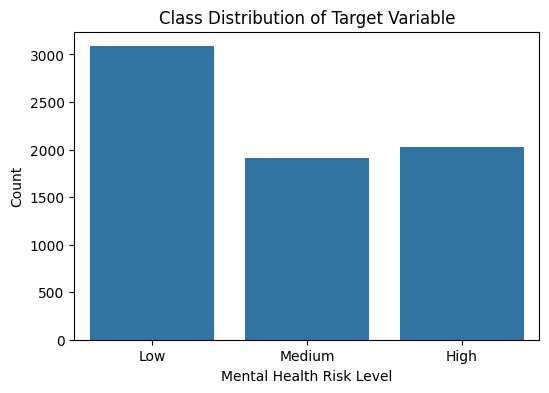

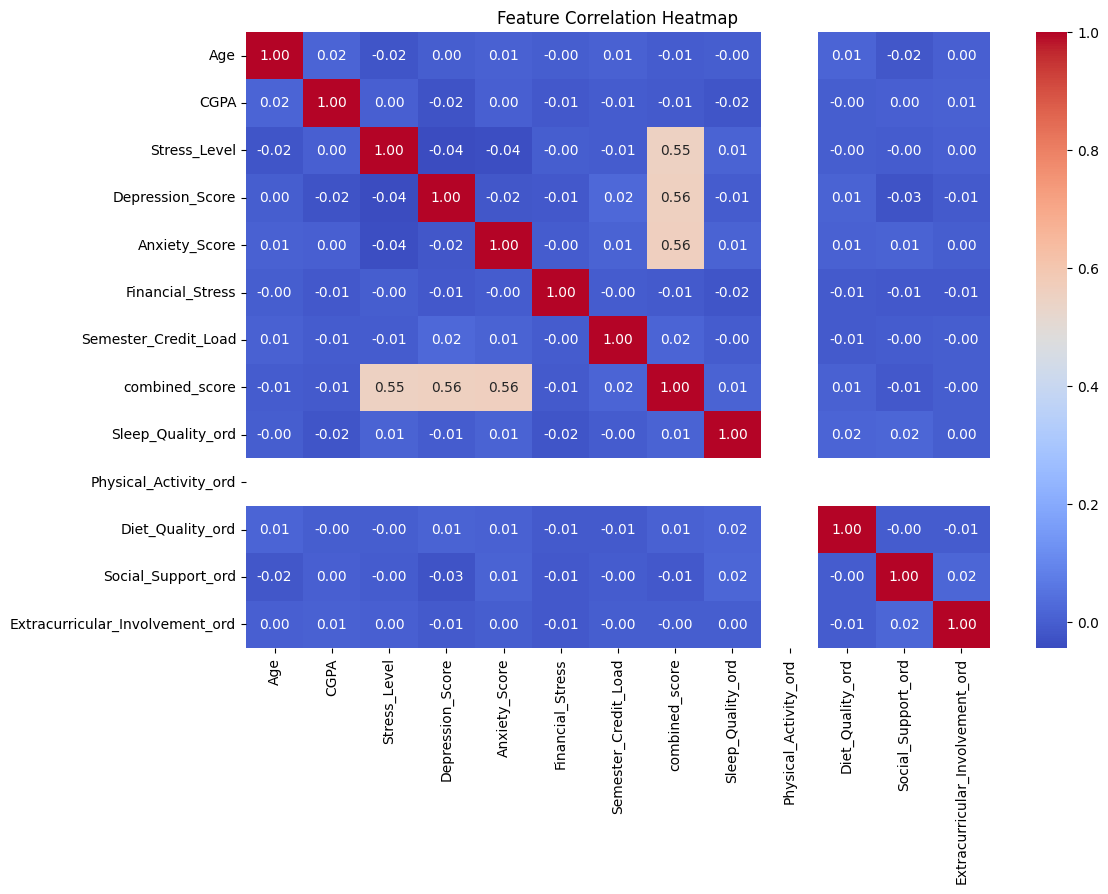

In [10]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Risk_Level", data=df, order=labels)
plt.title("Class Distribution of Target Variable")
plt.xlabel("Mental Health Risk Level")
plt.ylabel("Count")
plt.show()

# Correlation heatmap (only numeric features)
plt.figure(figsize=(12,8))
numerical_df = df.select_dtypes(include=np.number)
corr = numerical_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

## STEP 11: Train/Test Split

In [11]:
from sklearn.model_selection import train_test_split

# Features (X) = everything except target
X = df.drop(columns=["Risk_Level", "combined_score", "Risk_Level_encoded"], errors="ignore")
y = df["Risk_Level"]

# Train-test split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Target distribution in Train:\n", y_train.value_counts(normalize=True))
print("Target distribution in Test:\n", y_test.value_counts(normalize=True))


Train shape: (5617, 25)
Test shape: (1405, 25)
Target distribution in Train:
 Risk_Level
Low       0.439380
High      0.287876
Medium    0.272743
Name: proportion, dtype: float64
Target distribution in Test:
 Risk_Level
Low       0.439146
High      0.288256
Medium    0.272598
Name: proportion, dtype: float64


## STEP 12: Preprocessing Pipeline

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Identify categorical & numerical columns
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

# Numerical pipeline → Impute (median) + Scale
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline → Impute (most frequent) + OneHotEncode
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features)
    ]
)

print("Preprocessing pipeline created successfully.")

Numeric features: ['Age', 'CGPA', 'Stress_Level', 'Depression_Score', 'Anxiety_Score', 'Financial_Stress', 'Semester_Credit_Load', 'Sleep_Quality_ord', 'Physical_Activity_ord', 'Diet_Quality_ord', 'Social_Support_ord', 'Extracurricular_Involvement_ord']
Categorical features: ['Course', 'Gender', 'Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Social_Support', 'Relationship_Status', 'Substance_Use', 'Counseling_Service_Use', 'Family_History', 'Chronic_Illness', 'Extracurricular_Involvement', 'Residence_Type']
Preprocessing pipeline created successfully.


In [13]:
# ==============================
# STEP 12.5: Prepare Final Dataset for Modeling
# ==============================

# Define leakage columns (should not be predictors)
leakage_cols = ["Stress_Level", "Depression_Score", "Anxiety_Score", "combined_score", "Risk_Level"]

# Separate X and y safely
if "Risk_Level" not in df.columns:
    raise KeyError("Risk_Level column not found in dataset. Please check target creation step.")

X = df.drop(columns=[c for c in leakage_cols if c in df.columns], errors="ignore")
y = df["Risk_Level"]

print("Final features ready for modeling")
print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())

# Check for columns with all NaN (these break sklearn)
nan_cols = [c for c in X.columns if X[c].isna().all()]
if nan_cols:
    print("\nDropping columns with all NaN values:", nan_cols)
    X = X.drop(columns=nan_cols)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\nFinal shapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)


Final features ready for modeling
X shape: (7022, 22)
y distribution:
 Risk_Level
Low       3085
High      2022
Medium    1915
Name: count, dtype: int64

Dropping columns with all NaN values: ['Physical_Activity_ord']

Final shapes:
X_train: (4915, 21) X_test: (2107, 21)
y_train: (4915,) y_test: (2107,)


## STEP 13: Train & Evaluate Models

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Encode target variable to numerical labels for models that require it (like XGBoost)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Candidate models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

results = []

# Redefine numerical and categorical features based on X_train columns
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Numerical pipeline → Impute (median) + Scale
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline → Impute (most frequent) + OneHotEncode
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features)
    ]
)


for name, model in models.items():
    # Build pipeline (preprocessing + model)
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])

    # Train
    # Use encoded target only for models that need it (like XGBoost).
    # For others, use the original categorical labels.
    if name == "XGBoost":
        pipe.fit(X_train, le.transform(y_train)) # Encode y_train as well
    else:
        pipe.fit(X_train, y_train)


    # Predict
    y_pred = pipe.predict(X_test)

    # Decode predictions back to original labels for evaluation metrics
    if name == "XGBoost":
        y_pred = le.inverse_transform(y_pred)


    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    results.append({"Model": name, "Accuracy": acc, "F1 Score": f1})

    print("="*40)
    print(f"📊 {name}")
    print("Accuracy:", round(acc, 3))
    print("F1 Score:", round(f1, 3))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=le.classes_)) # Use le.classes_ for consistent order

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("\n🔎 Model Comparison:\n", results_df)

📊 Logistic Regression
Accuracy: 0.43
F1 Score: 0.353
Classification Report:
               precision    recall  f1-score   support

        High       0.37      0.22      0.28       607
         Low       0.45      0.81      0.58       926
      Medium       0.30      0.04      0.07       574

    accuracy                           0.43      2107
   macro avg       0.37      0.36      0.31      2107
weighted avg       0.39      0.43      0.35      2107

Confusion Matrix:
 [[134 448  25]
 [147 748  31]
 [ 84 466  24]]
📊 Decision Tree
Accuracy: 0.363
F1 Score: 0.363
Classification Report:
               precision    recall  f1-score   support

        High       0.31      0.30      0.30       607
         Low       0.44      0.43      0.43       926
      Medium       0.30      0.32      0.31       574

    accuracy                           0.36      2107
   macro avg       0.35      0.35      0.35      2107
weighted avg       0.36      0.36      0.36      2107

Confusion Matrix:
 [[184

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:52:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 XGBoost
Accuracy: 0.383
F1 Score: 0.367
Classification Report:
               precision    recall  f1-score   support

        High       0.31      0.25      0.28       607
         Low       0.45      0.58      0.51       926
      Medium       0.27      0.20      0.23       574

    accuracy                           0.38      2107
   macro avg       0.34      0.34      0.34      2107
weighted avg       0.36      0.38      0.37      2107

Confusion Matrix:
 [[153 324 130]
 [209 537 180]
 [133 325 116]]

🔎 Model Comparison:
                  Model  Accuracy  F1 Score
4              XGBoost  0.382534  0.366687
3    Gradient Boosting  0.419079  0.365163
1        Decision Tree  0.362601  0.363038
2        Random Forest  0.407214  0.357377
0  Logistic Regression  0.429995  0.353473


In [15]:
# ==============================
# STEP 14: Handle Class Imbalance with SMOTE
# ==============================
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Features and target
X = df.drop(columns=["Risk_Level", "combined_score"], errors='ignore') # Exclude combined_score as well
y = df["Risk_Level"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Before SMOTE:", y_train.value_counts())

# Apply preprocessing to X_train BEFORE applying SMOTE
X_train_processed = preprocessor.fit_transform(X_train)


# Apply SMOTE only on training data
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

print("After SMOTE:", y_train_res.value_counts())

# ==============================
# Retrain Models on Balanced Data
# ==============================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode target variable to numerical labels for models that require it (like XGBoost)
le = LabelEncoder()
# Fit on the original y to ensure all classes are known
le.fit(y)


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

results_smote = [] # Use a different variable name to avoid overwriting previous results

for name, model in models.items():
    print("="*40)
    print(f"📊 {name}")

    # Train on the resampled and preprocessed data
    # Use encoded target only for models that need it (like XGBoost).
    if name == "XGBoost":
         # Transform y_train_res for XGBoost
        model.fit(X_train_res, le.transform(y_train_res))
    else:
        model.fit(X_train_res, y_train_res)


    # Predict on the original (but preprocessed) X_test
    X_test_processed = preprocessor.transform(X_test)
    y_pred = model.predict(X_test_processed)

    # Decode predictions back to original labels for evaluation metrics
    if name == "XGBoost":
        y_pred = le.inverse_transform(y_pred)


    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    print("Accuracy:", round(acc, 3))
    print("F1 Score:", round(f1, 3))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=le.classes_)) # Use le.classes_ for consistent order


    results_smote.append({"Model": name, "Accuracy": acc, "F1 Score": f1})


# Compare models after SMOTE
results_smote_df = pd.DataFrame(results_smote).sort_values(by="F1 Score", ascending=False)
print("\nModel Comparison After SMOTE:")
print(results_smote_df)

Before SMOTE: Risk_Level
Low       2159
High      1415
Medium    1341
Name: count, dtype: int64
After SMOTE: Risk_Level
Low       2159
Medium    2159
High      2159
Name: count, dtype: int64
📊 Logistic Regression
Accuracy: 0.384
F1 Score: 0.38
Classification Report:
               precision    recall  f1-score   support

        High       0.34      0.51      0.41       607
         Low       0.51      0.41      0.46       926
      Medium       0.26      0.20      0.22       574

    accuracy                           0.38      2107
   macro avg       0.37      0.38      0.36      2107
weighted avg       0.39      0.38      0.38      2107

Confusion Matrix:
 [[312 158 137]
 [358 384 184]
 [256 205 113]]
📊 Decision Tree
Accuracy: 0.349
F1 Score: 0.351
Classification Report:
               precision    recall  f1-score   support

        High       0.30      0.32      0.31       607
         Low       0.44      0.41      0.43       926
      Medium       0.27      0.28      0.27       5

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:53:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.382
F1 Score: 0.366
Classification Report:
               precision    recall  f1-score   support

        High       0.31      0.26      0.28       607
         Low       0.45      0.58      0.51       926
      Medium       0.27      0.19      0.22       574

    accuracy                           0.38      2107
   macro avg       0.34      0.34      0.34      2107
weighted avg       0.36      0.38      0.37      2107

Confusion Matrix:
 [[158 327 122]
 [211 537 178]
 [141 323 110]]

Model Comparison After SMOTE:
                 Model  Accuracy  F1 Score
0  Logistic Regression  0.383958  0.380093
3    Gradient Boosting  0.404366  0.374862
2        Random Forest  0.403417  0.370544
4              XGBoost  0.382060  0.365792
1        Decision Tree  0.348837  0.350780


## STEP 14: Visualize Model Performance

/tmp/ipython-input-4219998968.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1 Score", y="Model", data=results_df, palette="viridis")


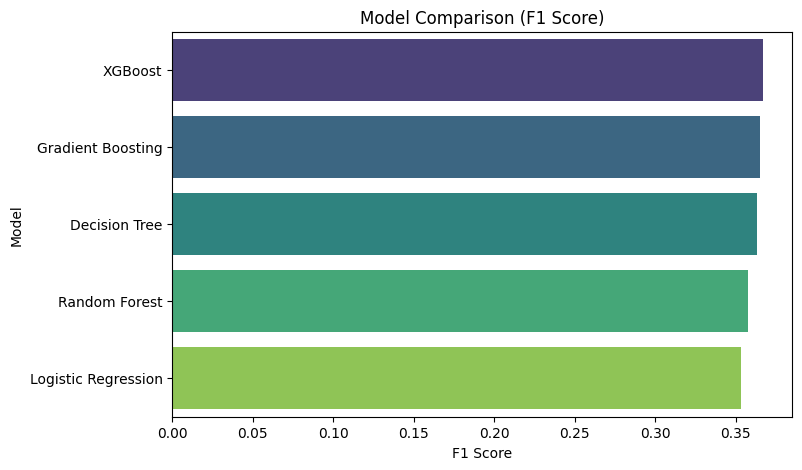

In [16]:
plt.figure(figsize=(8,5))
sns.barplot(x="F1 Score", y="Model", data=results_df, palette="viridis")
plt.title("Model Comparison (F1 Score)")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.show()

## Step 15: Model Comparison & Visualization

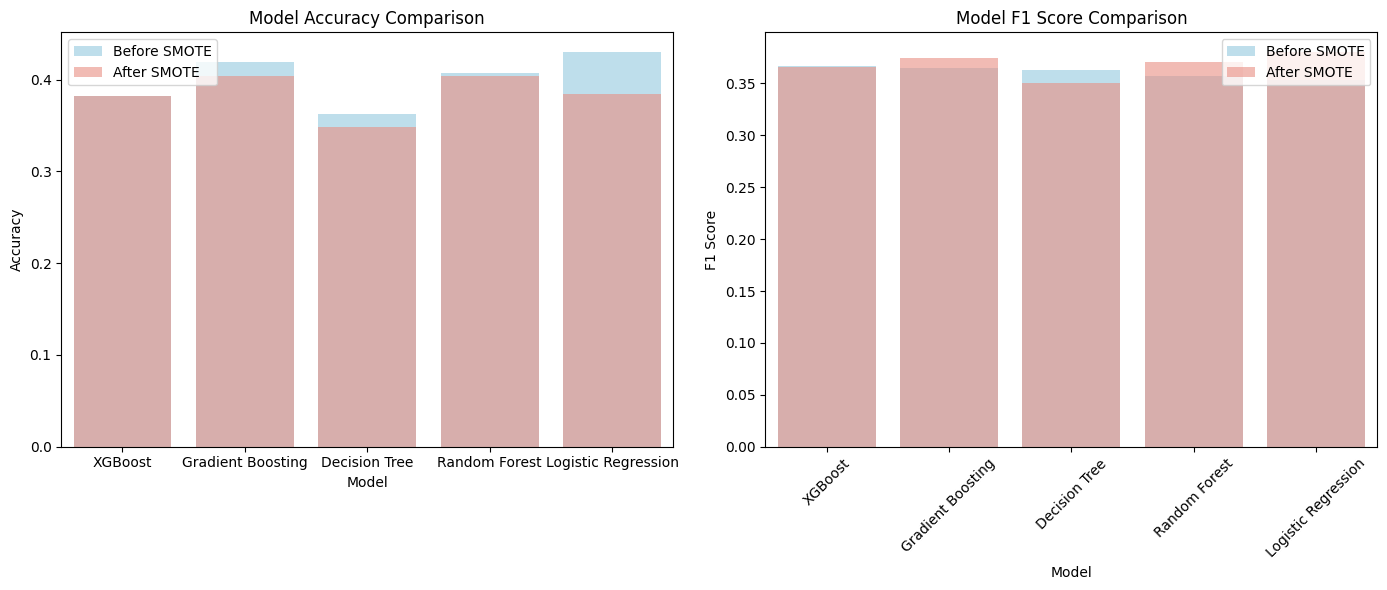

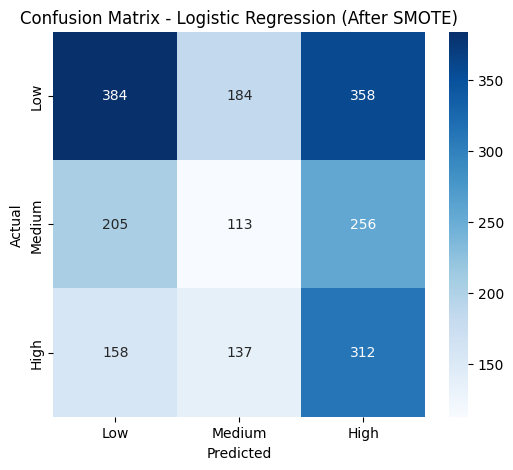

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================
# 1️⃣ Bar Chart for Model Comparison
# ===========================
def plot_model_comparison(results_before, results_after):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Accuracy Comparison
    sns.barplot(x="Model", y="Accuracy", data=results_before, color="skyblue", alpha=0.6, label="Before SMOTE", ax=axes[0])
    sns.barplot(x="Model", y="Accuracy", data=results_after, color="salmon", alpha=0.6, label="After SMOTE", ax=axes[0])
    axes[0].set_title("Model Accuracy Comparison")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    # F1 Score Comparison
    sns.barplot(x="Model", y="F1 Score", data=results_before, color="skyblue", alpha=0.6, label="Before SMOTE", ax=axes[1])
    sns.barplot(x="Model", y="F1 Score", data=results_after, color="salmon", alpha=0.6, label="After SMOTE", ax=axes[1])
    axes[1].set_title("Model F1 Score Comparison")
    axes[1].set_ylabel("F1 Score")
    axes[1].legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call function with your results
plot_model_comparison(results_df, results_smote_df)

# ===========================
# 2️⃣ Confusion Matrix Heatmap (Best Model)
# ===========================
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=['Low', 'Medium', 'High'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Example: Confusion Matrix for Logistic Regression (after SMOTE)
plot_confusion_matrix(y_test, models["Logistic Regression"].predict(preprocessor.transform(X_test)), "Logistic Regression (After SMOTE)")